### Using S&P 500 and Vix Historical Data to Predict Bitcoin Investment Return

In this analysis, we attempt to examine S&P 500 and Vix historical data and determine if such data can be used to predict return on future Bitcoin investments.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

def date_parser(date):
    return pd.to_datetime(date).date

### Data Collection and Labeling

In [3]:
# Bitcoin Data Collection
coin_df = pd.read_csv('Data/coin_Bitcoin.csv',
                     index_col='Date',
                     parse_dates=['Date'],
                     date_parser=date_parser)

# We only are concerned with Bitcoin's Closing Price day by day
btc_close_df = pd.DataFrame(index=coin_df.index)
btc_close_df['Close'] = coin_df['Close']

btc_close_df.rename(columns={'Close': 'close'}, inplace=True)

btc_close_df.head()

,close
Date,
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999
2013-05-03,97.750000


In [4]:
# Next we read in the Vix dataset
new_column_names = {
    'OPEN': 'Open',
    'HIGH': 'High',
    'LOW': 'Low',
    'CLOSE': 'Close'
}

vix_df = pd.read_csv('index_data/VIX_History.csv',
                    index_col='DATE',
                    parse_dates=['DATE'],
                    date_parser=date_parser
                    )

vix_df.rename(columns=new_column_names, inplace=True)
vix_df.head()

,Open,High,Low,Close
DATE,,,,
1990-01-02,17.24,17.24,17.24,17.24
1990-01-03,18.19,18.19,18.19,18.19
1990-01-04,19.22,19.22,19.22,19.22
1990-01-05,20.11,20.11,20.11,20.11
1990-01-08,20.26,20.26,20.26,20.26


In [5]:
# Next we read in S&P 500 Dataset
sp_df = pd.read_csv('index_data/sp_500_historical.csv',
                   index_col='Date',
                   parse_dates=['Date'],
                   date_parser=date_parser)

new_column_names = {
    "Close/Last": "Close"
}

sp_df.rename(columns=new_column_names, inplace=True)

# Drop Volume. There are no non '--' values for Volume
sp_df.drop('Volume', axis=1, inplace=True)

# Some rows of the sp_df have bad data (such as columns with a value of 0 that skew the data). So we drop these
sp_df = sp_df[sp_df['Close'] != 0]
sp_df = sp_df[sp_df['Open'] != 0]
sp_df = sp_df[sp_df['High'] != 0]
sp_df = sp_df[sp_df['Low'] != 0]

# The S&P 500 Dataframe appears to be backwards. Let's reverse it so that it is more in line with out coin set
# This probably doesn't matter, but just in case.
sp_df = sp_df.reindex(index=sp_df.index[::-1])
sp_df.head()

,Close,Open,High,Low
Date,,,,
2011-03-29,1319.44,1310.19,1319.45,1305.26
2011-03-30,1328.26,1319.44,1331.74,1321.89
2011-03-31,1325.83,1328.26,1329.77,1325.03
2011-04-01,1332.41,1325.83,1337.85,1328.89
2011-04-04,1332.87,1332.41,1336.74,1329.10


In [6]:
# Now we merge the data together
df = pd.DataFrame(index=coin_df.index)
df[['sp-close', 'sp-open', 'sp-high', 'sp-low']] = sp_df[['Close', 'Open', 'High', 'Low']]
df[['vix-close', 'vix-open', 'vix-high', 'vix-low']] = vix_df[['Close', 'Open', 'High', 'Low']]
df.head()

,sp-close,sp-open,sp-high,sp-low,vix-close,vix-open,vix-high,vix-low
Date,,,,,,,,
2013-04-29,1593.61,1582.34,1596.65,1582.34,13.71,13.72,13.94,13.36
2013-04-30,1597.57,1593.58,1597.57,1586.50,13.52,13.71,14.28,13.51
2013-05-01,1582.70,1597.55,1597.55,1581.28,14.49,13.88,14.67,13.87
2013-05-02,1597.59,1582.77,1598.60,1582.77,13.59,14.48,14.48,13.58
2013-05-03,1614.42,1597.60,1618.46,1597.60,12.85,12.92,13.15,12.77


In [7]:
df['btc-close'] = coin_df['Close']

# Drop NaN rows
df.dropna(inplace=True)
df.head()

,sp-close,sp-open,sp-high,sp-low,vix-close,vix-open,vix-high,vix-low,btc-close
Date,,,,,,,,,
2013-04-29,1593.61,1582.34,1596.65,1582.34,13.71,13.72,13.94,13.36,144.539993
2013-04-30,1597.57,1593.58,1597.57,1586.50,13.52,13.71,14.28,13.51,139.000000
2013-05-01,1582.70,1597.55,1597.55,1581.28,14.49,13.88,14.67,13.87,116.989998
2013-05-02,1597.59,1582.77,1598.60,1582.77,13.59,14.48,14.48,13.58,105.209999
2013-05-03,1614.42,1597.60,1618.46,1597.60,12.85,12.92,13.15,12.77,97.750000


### Data Visualization

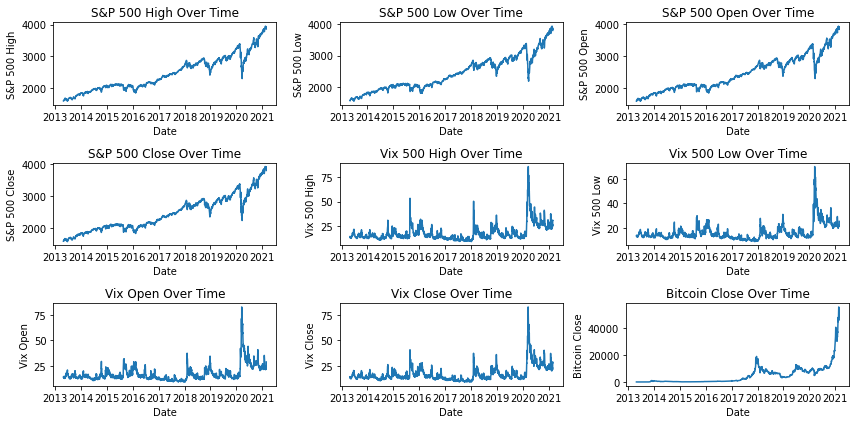

In [8]:
# A basic visualization of Date vs the coin_df columns
fig = plt.figure(figsize=(12, 6))

# S&P 500 High over time
high_axis = fig.add_subplot(3, 3, 1)
high_axis.plot(df.index, df['sp-high'])
high_axis.set_title('S&P 500 High Over Time')
high_axis.set_xlabel('Date')
high_axis.set_ylabel('S&P 500 High')

# S&P 500 Low over time
low_axis = fig.add_subplot(3, 3, 2)
low_axis.plot(df.index, df['sp-low'])
low_axis.set_title('S&P 500 Low Over Time')
low_axis.set_xlabel('Date')
low_axis.set_ylabel('S&P 500 Low')

# S&P 500 Open over time
open_axis = fig.add_subplot(3, 3, 3)
open_axis.plot(df.index, df['sp-open'])
open_axis.set_title('S&P 500 Open Over Time')
open_axis.set_xlabel('Date')
open_axis.set_ylabel('S&P 500 Open')

# S&P 500 Close over time
close_axis = fig.add_subplot(3, 3, 4)
close_axis.plot(df.index, df['sp-close'])
close_axis.set_title('S&P 500 Close Over Time')
close_axis.set_xlabel('Date')
close_axis.set_ylabel('S&P 500 Close')

# Vix High over time
high_axis = fig.add_subplot(3, 3, 5)
high_axis.plot(df.index, df['vix-high'])
high_axis.set_title('Vix 500 High Over Time')
high_axis.set_xlabel('Date')
high_axis.set_ylabel('Vix 500 High')

# Vix Low over time
low_axis = fig.add_subplot(3, 3, 6)
low_axis.plot(df.index, df['vix-low'])
low_axis.set_title('Vix 500 Low Over Time')
low_axis.set_xlabel('Date')
low_axis.set_ylabel('Vix 500 Low')

# Vix Open over time
open_axis = fig.add_subplot(3, 3, 7)
open_axis.plot(df.index, df['vix-open'])
open_axis.set_title('Vix Open Over Time')
open_axis.set_xlabel('Date')
open_axis.set_ylabel('Vix Open')

# Vix Close over time
close_axis = fig.add_subplot(3, 3, 8)
close_axis.plot(df.index, df['vix-close'])
close_axis.set_title('Vix Close Over Time')
close_axis.set_xlabel('Date')
close_axis.set_ylabel('Vix Close')

# Bitcoin Return over time
return_axis = fig.add_subplot(3, 3, 9)
return_axis.plot(df.index, df['btc-close'])
return_axis.set_title('Bitcoin Close Over Time')
return_axis.set_xlabel('Date')
return_axis.set_ylabel('Bitcoin Close')

plt.tight_layout()
plt.show()

### Preprocessing

We are attempting to observe how the trends of our data relate to Bitcoin. We will pre-process our data-set by calculating the percent change for each of our columns.

In [9]:
for column in df.columns:
    df[column] = df[column].pct_change()
df.head()

,sp-close,sp-open,sp-high,sp-low,vix-close,vix-open,vix-high,vix-low,btc-close
Date,,,,,,,,,
2013-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,0.002485,0.007103,0.000576,0.002629,-0.013858,-0.000729,0.024390,0.011228,-0.038328
2013-05-01,-0.009308,0.002491,-0.000013,-0.003290,0.071746,0.012400,0.027311,0.026647,-0.158345
2013-05-02,0.009408,-0.009252,0.000657,0.000942,-0.062112,0.043228,-0.012952,-0.020908,-0.100692
2013-05-03,0.010535,0.009370,0.012423,0.009370,-0.054452,-0.107735,-0.091851,-0.059647,-0.070906


---

### Class Assignment

With this analysis, we found that our multi-class prediction (as seen in our Bitcoin historical data analysis) did not bear promising results here. However, simply predicting whether the price of Bitcoin will move up or down is useful information for an investor. So we attempt a binary classification problem here on return: 'postive' return and 'negative' return.

In [12]:
def get_class(return_val):
    if return_val > 0:
        return 'positive'
    else:
        return 'negative'

# Shift percent change column up 1 row (since in theory we use the current day to predict the return of the next day)
df['return'] = df['btc-close'].shift(-1)
# Assign Class
df['return'] = [get_class(return_val) for return_val in df['btc-close']]

df.dropna(inplace=True)
df.head()

,sp-close,sp-open,sp-high,sp-low,vix-close,vix-open,vix-high,vix-low,btc-close,return
Date,,,,,,,,,,
2013-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
2013-04-30,0.002485,0.007103,0.000576,0.002629,-0.013858,-0.000729,0.024390,0.011228,-0.038328,negative
2013-05-01,-0.009308,0.002491,-0.000013,-0.003290,0.071746,0.012400,0.027311,0.026647,-0.158345,negative
2013-05-02,0.009408,-0.009252,0.000657,0.000942,-0.062112,0.043228,-0.012952,-0.020908,-0.100692,negative
2013-05-03,0.010535,0.009370,0.012423,0.009370,-0.054452,-0.107735,-0.091851,-0.059647,-0.070906,negative


In [14]:
class_counts = {}
for class_ in df['return']:
    class_counts[class_] = class_counts.get(class_, 0) + 1
print(class_counts)

{'negative': 913, 'positive': 1056}


---

### Model Evaluation/Parameter Tuning

Here, we evaluate some models.

In [22]:
# To decide on the best model, we should fine tune the parameters of the models in consideration to see
# the best performances of our models.

# Here, we use a StandardScaler on Vix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

X = df[['sp-close', 'sp-open', 'sp-high', 'sp-low', 'vix-close', 'vix-open', 'vix-high', 'vix-low']]
y = df['return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

transformer = StandardScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

### Logistic Regression Evaluation

In [23]:
# Logistic Regression Parameter Tuning
from sklearn.linear_model import LogisticRegression
param_grid = {  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                }

lr = LogisticRegression(max_iter=2000)
grid = GridSearchCV(lr, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
lr_best_params = grid.best_params_

Best grid score: 0.54
Grid test score: 0.52
Best grid parameters: {'C': 0.01}


### Decision Tree Evaluation

In [24]:
# Decision Tree Parameter Tuning
from sklearn.tree import DecisionTreeClassifier
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10,12,14,16,18,20,25,30,40,50,70]
}
dt = DecisionTreeClassifier()
grid = GridSearchCV(dt, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
dt_best_params = grid.best_params_

Best grid score: 0.55
Grid test score: 0.54
Best grid parameters: {'criterion': 'gini', 'max_depth': 6}


### KNN Evaluation

In [25]:
# K-Nearest Neighbors Parameter Tuning
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
knn_best_params = grid.best_params_

Best grid score: 0.56
Grid test score: 0.50
Best grid parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


### Retraining with Best Parameters


In [26]:
# Let's retrain the models using the fine-tuned parameters found
# so we can examine the confusion matrix and scoring report and make a conclusion.
lr = LogisticRegression(max_iter=2000, C=lr_best_params['C'])
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print('Logistic Regression Score: {:.2f}'.format(lr.score(X_test, y_test)))

dt = DecisionTreeClassifier(criterion=dt_best_params['criterion'], max_depth=dt_best_params['max_depth'])
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print('Decision Tree Score: {:.2f}'.format(dt.score(X_test, y_test)))

knn = KNeighborsClassifier(metric=knn_best_params['metric'], n_neighbors=knn_best_params['n_neighbors'], weights=knn_best_params['weights'])
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('KNN Score: {:.2f}'.format(knn.score(X_test, y_test)))

Logistic Regression Score: 0.52
Decision Tree Score: 0.54
KNN Score: 0.50


---

### Score Reporting

The accuracy above indicates that the models cannot use the market trends observed through the S&P 500 and Vix datasets to make an accurate prediction (since a random guess is 50\% and our models above did not do significantly better)

### Confusion Matrices

In [28]:
from sklearn.metrics import confusion_matrix
labels = ["positive", "negative"]
print("Logistic Regression Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, lr_pred), index=labels, columns=labels), '\n')
print("Decision Tree Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, dt_pred), index=labels, columns=labels), '\n')
print("KNN Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, knn_pred), index=labels, columns=labels), '\n')

Logistic Regression Confusion Matrix:
          positive  negative
positive        26       252
negative        32       281 

Decision Tree Classifier Confusion Matrix:
          positive  negative
positive        66       212
negative        62       251 

KNN Classifier Confusion Matrix:
          positive  negative
positive       123       155
negative       139       174 



### Classification Reports (f1-score, precision, accuracy, etc.)

In [29]:
from sklearn.metrics import classification_report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred), '\n')
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, dt_pred), '\n')
print("KNN Classifier Classification Report:")
print(classification_report(y_test, knn_pred), '\n')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.45      0.09      0.15       278
    positive       0.53      0.90      0.66       313

    accuracy                           0.52       591
   macro avg       0.49      0.50      0.41       591
weighted avg       0.49      0.52      0.42       591
 

Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

    negative       0.52      0.24      0.33       278
    positive       0.54      0.80      0.65       313

    accuracy                           0.54       591
   macro avg       0.53      0.52      0.49       591
weighted avg       0.53      0.54      0.50       591
 

KNN Classifier Classification Report:
              precision    recall  f1-score   support

    negative       0.47      0.44      0.46       278
    positive       0.53      0.56      0.54       313

    accuracy                           0.50      

### Interpretation of Metrics

Here, we can see that the classifiers we have constructed do not serve as good predictors for the trend we are attempting to observe. As seen through the confusion matrices, the models constructed tend to simply predict one class more frequently than the other or (as seen with KNN) an even distribution of both classes. Regardless, the models created are insufficient.

However, this gives us an interesting insight about Bitcoin trends in that market factors do not have much effect on Bitcoin's price. What one can infer from this is that when the market is doing well or is in turmoil, investors are indifferent about Bitcoin. One can postulate that it is because investors do not see Bitcoin as a safe investment yet.